In [1]:
# !pip install yfinance ib_async

In [2]:
# !pip install fastapi "uvicorn[standard]"
# !pip install aiohttp

🚀 Trading memory instances will be created based on trading mode...
🚀 Using AUGMENTED news system (IBKR + GCS + Gemini)
🧠 Initializing Trading Memory Store (LIVE MODE) with: trading_memory.db
🔍 Found 37 existing columns in trading_memories
✅ Database schema up to date - all forecast columns already exist
✅ Database tables created successfully
🌅 Started new trading day: 2025-08-19
✅ Trading Memory Store (LIVE MODE) initialized successfully


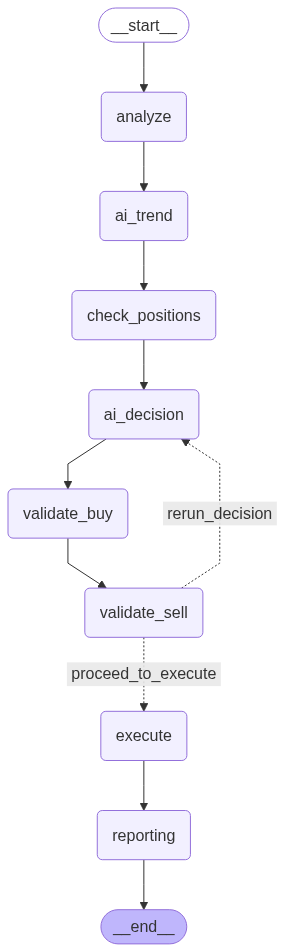

In [3]:
# /trading_bot/main_trading_notebook.ipynb

# === IMPORTS AND SETUP ===
import asyncio
import json
from datetime import datetime
from typing import TypedDict, Dict, List

from langgraph.graph import StateGraph, END
from IPython.display import Image, display

from config import *
from utils import *
from market_data import *
from agent import *
from reporting import *
from diagnostics import *
from sp500_tracker import *

import nest_asyncio
nest_asyncio.apply()
BACKTEST_MODE = False # Set to False for live trading
# ENHANCED: Get news summary with augmented sources (IBKR + GCS + Gemini)
# Option 1: Use augmented news (recommended) with fallback
try:
    from news_augmented import get_news_summary_for_trading
    from news_gcs_integration import initialize_news_cache
    NEWS_SYSTEM = "AUGMENTED"
    print("🚀 Using AUGMENTED news system (IBKR + GCS + Gemini)")
except ImportError as e:
    print(f"⚠️ Augmented news import failed: {e}")
    print("🔄 Falling back to IBKR-only news system")
    from news_working import get_news_summary_for_trading
    NEWS_SYSTEM = "IBKR_ONLY"
    
    # Create dummy function for compatibility
    async def initialize_news_cache(days_back=3):
        print("📰 News cache initialization skipped (IBKR-only mode)")
        return True

from memory_store import store_cycle_memory, get_memory_enhanced_prompt_context
# from memory_store import show_memory_status, test_memory_with_portfolio
from memory_store import trading_memory, get_memory_stats, SimpleTradingMemoryStore
if trading_memory is None:
  trading_memory = SimpleTradingMemoryStore()
    
### Stock parallel processing
from parallel_ai_recommendations import get_ai_portfolio_recommendations_with_news_parallel

# === AGENT STATE DEFINITION ===
class PortfolioState(TypedDict):
    """Defines the state that flows through the agent graph."""
    timestamp: str
    cycle_number: int
    portfolio_stocks: List[str]
    stock_data: Dict[str, Dict]  # 5-minute data
    stock_data_1h: Dict[str, Dict]  # 1-hour data
    stock_prices: Dict[str, float]
    stock_smas: Dict[str, float]
    ai_trend_analysis: Dict[str, Dict]
    positions: Dict[str, int]
    stock_pnls: Dict[str, float]
    purchase_prices: Dict[str, float]
    total_portfolio_value: float
    total_unrealized_pnl: float
    total_trades: int
    total_fees_paid: float
    cash_available: float
    ai_recommendations: Dict[str, Dict]
    executed_trades: List[Dict]
    portfolio_allocation: Dict[str, float]
    session_start_time: str
    session_id: str
    cycle_history: List[Dict]
    validation_attempts: int
    validation_history: List[Dict]
    final_decision_logic: str
    validation_feedback: str
    # --- NEW FIELD FOR STRATEGY ---
    aggressive_mode: bool
    memory_context: str
    sp500_data: Dict[str, Any]
    benchmark_comparison: Dict[str, Any]
    news_sentiment: Dict[str, Dict]
    price_peaks: Dict[str, float]  # Added for trailing stop tracking
    # --- NEW FIELDS FOR SEPARATE VALIDATION ---
    buy_validation_result: Dict[str, Any]
    sell_validation_result: Dict[str, Any]
    buy_validation_attempts: int
    sell_validation_attempts: int


# === AGENT GRAPH NODES ===
@time_function("Market Data Analysis")
async def analyze_portfolio_node(state: PortfolioState) -> PortfolioState:
    """Node to fetch market data and update the state - DUAL TIMEFRAME VERSION."""
    print(f"\n--- Cycle {state['cycle_number']}: Analyzing Market (Dual Timeframe) ---")
    
    # Time dual timeframe stock data fetching
    with time_code_block("Dual Timeframe Stock Data Batch Fetch"):
        if BACKTEST_MODE:
            # Use the new backtesting data source (5-minute only for now)
            print("📊 Fetching 5-minute backtest data...")
            stock_data_5m = await get_backtest_data_batch(state['portfolio_stocks'])
            stock_data_1h = {}  # Backtest mode uses 5-min only for now
        else:
            # Fetch both timeframes in parallel for live trading
            print("📊 Fetching DUAL TIMEFRAME data (5min + 1hr) in parallel...")
            
            async def fetch_5min_data():
                with time_code_block("5-Minute Data Fetch"):
                    return await get_stock_data_batch(state['portfolio_stocks'])
            
            async def fetch_1hr_data():
                with time_code_block("1-Hour Data Fetch"):
                    return await get_stock_data_batch_1h(state['portfolio_stocks'])
            
            # Run both data fetches in parallel
            stock_data_5m, stock_data_1h = await asyncio.gather(
                fetch_5min_data(),
                fetch_1hr_data()
            )
    
    state['timestamp'] = datetime.now().isoformat()
    state['stock_data'] = stock_data_5m  # Primary timeframe for prices
    state['stock_data_1h'] = stock_data_1h  # Secondary timeframe for trend confirmation
    state['stock_prices'] = {s: d.get('current_price', 0) for s, d in stock_data_5m.items()}
    state['stock_smas'] = {s: d.get('sma_20', 0) for s, d in stock_data_5m.items()}
    
    valid_count_5m = len([s for s, d in stock_data_5m.items() if d.get('valid')])
    valid_count_1h = len([s for s, d in stock_data_1h.items() if d.get('valid')]) if stock_data_1h else 0
    
    print(f"✅ Dual timeframe analysis complete:")
    print(f"   📈 5-minute data: {valid_count_5m}/{len(state['portfolio_stocks'])} stocks")
    print(f"   📊 1-hour data: {valid_count_1h}/{len(state['portfolio_stocks'])} stocks")
    
    # Time S&P 500 operations
    with time_code_block("S&P 500 Data Fetch"):
        print("📊 Fetching S&P 500 benchmark data...")
        sp500_data = await sp500_tracker.get_sp500_data()
        state['sp500_data'] = sp500_data
        
        if sp500_data.get('success'):
            sp500_tracker.log_sp500_data(state, sp500_data)
            print(f"📈 S&P 500: ${sp500_data['price']:.2f} ({sp500_data['change_pct']:+.2f}%)")
            
            # Calculate benchmark comparison
            benchmark_comparison = sp500_tracker.calculate_benchmark_comparison(state)
            state['benchmark_comparison'] = benchmark_comparison
            
            if 'error' not in benchmark_comparison:
                alpha = benchmark_comparison.get('alpha', 0)
                status = "🟢 OUTPERFORMING" if alpha > 0 else "🔴 UNDERPERFORMING"
                print(f"⚖️ vs S&P 500: {status} by {alpha:+.2f}%")
        else:
            print("⚠️ Could not fetch S&P 500 data")
            state['sp500_data'] = {'success': False}
            state['benchmark_comparison'] = {}
    
    return state



# 🔧 COMPREHENSIVE FIX: Replace your parallel_analysis_node with this version

@time_function("Parallel AI & News Analysis")
async def parallel_analysis_node(state: PortfolioState) -> PortfolioState:
    """Run AI trend analysis and news analysis in parallel - DUAL TIMEFRAME VERSION."""
    print(f"🤖 Running parallel DUAL TIMEFRAME AI trend analysis and {NEWS_SYSTEM} news analysis...")
    
    # Create tasks that can run in parallel
    async def ai_analysis():
        with time_code_block("Dual Timeframe AI Trend Analysis"):
            ai_trend_analysis = {}
            
            # PARALLELIZE THE DUAL TIMEFRAME AI ANALYSIS FOR EACH STOCK
            async def analyze_single_stock_dual(symbol):
                symbol_start = time.time()
                
                # Use dual timeframe analysis if 1-hour data is available
                stock_data_5m = state['stock_data'].get(symbol, {})
                stock_data_1h = state.get('stock_data_1h', {}).get(symbol, {})
                
                if stock_data_1h.get('valid', False) and stock_data_5m.get('valid', False):
                    # Use dual timeframe analysis
                    analysis = await get_ai_trend_analysis_dual(stock_data_5m, stock_data_1h, symbol)
                    timeframe_used = "5M+1H"
                else:
                    # Fallback to single timeframe
                    analysis = await get_ai_trend_analysis(state['stock_data'], symbol)
                    timeframe_used = "5M only"
                
                symbol_time = time.time() - symbol_start
                print(f"  📊 {symbol} AI analysis ({timeframe_used}): {symbol_time:.2f}s")
                return symbol, analysis
            
            # Create tasks for all stocks to run in parallel
            tasks = [analyze_single_stock_dual(symbol) for symbol in state['portfolio_stocks']]
            
            # Run all stock analyses in parallel
            results = await asyncio.gather(*tasks)
            
            # Collect results
            for symbol, analysis in results:
                ai_trend_analysis[symbol] = analysis
            
            return ai_trend_analysis
    
    async def news_analysis():
        news_label = "Augmented News Analysis (IBKR + GCS + Gemini)" if NEWS_SYSTEM == "AUGMENTED" else "IBKR News Analysis"
        with time_code_block(news_label):
            # Use the enhanced news system that combines IBKR + GCS + Gemini (or fallback to IBKR only)
            news_summary = await get_news_summary_for_trading()
            return news_summary
    
    # Run both in parallel
    ai_results, news_results = await asyncio.gather(
        ai_analysis(),
        news_analysis()
    )
    
    # 🔧 CRITICAL FIX: Explicitly set both fields in the SAME state object
    state['ai_trend_analysis'] = ai_results
    state['news_sentiment'] = news_results
    
    # 🔍 DEBUG: Verify BOTH fields are properly stored
    print(f"\n🔍 {NEWS_SYSTEM} NEWS DATA STORED IN STATE:")
    print(f"   📊 AI trend keys: {list(ai_results.keys())}")
    print(f"   📊 News sentiment keys: {list(news_results.keys())}")
    print(f"   📊 State ai_trend_analysis keys: {list(state.get('ai_trend_analysis', {}).keys())}")
    print(f"   📊 State news_sentiment keys: {list(state.get('news_sentiment', {}).keys())}")
    print(f"   🔍 State type: {type(state)}")
    print(f"   🔍 State has news_sentiment key: {'news_sentiment' in state}")
    
    # Log enhanced news insights
    for symbol, news in news_results.items():
        if news.get('has_news', False):
            sentiment_emoji = news.get('sentiment_emoji', '📰')
            sentiment_label = news.get('sentiment_label', 'UNKNOWN')
            sources_used = news.get('sources_used', 1)
            confidence = news.get('confidence_level', 'MEDIUM')
            
            if NEWS_SYSTEM == "AUGMENTED":
                print(f"📰 {symbol}: {sentiment_emoji} {sentiment_label} ({confidence} confidence, {sources_used} sources)")
                
                # Show key themes if available
                key_themes = news.get('key_themes', [])
                if key_themes:
                    print(f"   🎯 Themes: {', '.join(key_themes[:2])}")
            else:
                print(f"📰 {symbol}: {sentiment_emoji} {sentiment_label}")
    
    print(f"✅ Parallel dual timeframe analysis complete with {NEWS_SYSTEM} news sources.")
    
    # 🔧 CRITICAL: Return the same state object (not a copy)
    return state

# 3. THIRD: Also update check_positions_node to be more explicit
@time_function("Position Checking")
async def check_positions_node(state: PortfolioState) -> PortfolioState:
    """Node to check current portfolio positions and value."""
    print("📊 Checking portfolio positions and value...")
    
    # 🔍 DEBUG: Check incoming state with explicit field checks
    print(f"🔍 INCOMING STATE ANALYSIS:")
    print(f"   📊 State type: {type(state)}")
    print(f"   📊 Has news_sentiment key: {'news_sentiment' in state}")
    print(f"   📊 Has ai_trend_analysis key: {'ai_trend_analysis' in state}")
    print(f"   📊 Has stock_data_1h key: {'stock_data_1h' in state}")
    
    if 'news_sentiment' in state:
        news_count = len(state['news_sentiment'])
        print(f"   📰 News sentiment data: {news_count} symbols")
        print(f"   📰 News symbols: {list(state['news_sentiment'].keys())}")
    else:
        print(f"   🚨 CRITICAL: news_sentiment key missing from state!")
        print(f"   📊 Available keys: {list(state.keys())}")
    
    # 🔧 BACKTEST MODE FIX: Use simulated values in backtest mode
    if BACKTEST_MODE:
        print("🧪 BACKTEST MODE: Using simulated portfolio values")
        
        # Initialize positions if first cycle or preserve existing positions
        if state['cycle_number'] == 1 or not state.get('positions'):
            positions = {symbol: 0 for symbol in state['portfolio_stocks']}
            pnls = {symbol: 0.0 for symbol in state['portfolio_stocks']}
            purchase_prices = {symbol: 0.0 for symbol in state['portfolio_stocks']}
            cash = 10000.0  # Start with $10,000 for backtesting
            portfolio_value = cash
        else:
            # Preserve existing positions from previous cycles
            positions = state.get('positions', {symbol: 0 for symbol in state['portfolio_stocks']})
            pnls = state.get('stock_pnls', {symbol: 0.0 for symbol in state['portfolio_stocks']})
            purchase_prices = state.get('purchase_prices', {symbol: 0.0 for symbol in state['portfolio_stocks']})
            cash = state.get('cash_available', 10000.0)
            
            # Calculate portfolio value based on current positions and prices
            stock_value = sum(positions.get(symbol, 0) * state['stock_prices'].get(symbol, 0) 
                            for symbol in state['portfolio_stocks'])
            portfolio_value = stock_value + cash
            
            # Update P&L based on current prices vs purchase prices
            for symbol in state['portfolio_stocks']:
                if positions.get(symbol, 0) > 0 and purchase_prices.get(symbol, 0) > 0:
                    current_price = state['stock_prices'].get(symbol, 0)
                    purchase_price = purchase_prices.get(symbol, 0)
                    position_size = positions.get(symbol, 0)
                    pnls[symbol] = (current_price - purchase_price) * position_size
                else:
                    pnls[symbol] = 0.0
        
        print(f"💰 Backtest Portfolio: ${portfolio_value:,.2f} (Cash: ${cash:,.2f})")
        
    else:
        # Live trading mode - use actual IB data
        positions, pnls, purchase_prices = await get_all_positions()
        portfolio_value, cash = await get_portfolio_summary()
    
    # Calculate allocations
    allocations = {}
    for symbol in state['portfolio_stocks']:
        if portfolio_value > 0:
            stock_value = positions.get(symbol, 0) * state['stock_prices'].get(symbol, 0)
            allocations[symbol] = (stock_value / portfolio_value) * 100
        else:
            allocations[symbol] = 0.0
    
    # 🔧 CRITICAL: Update fields in the SAME state object INCLUDING purchase prices
    state['positions'] = positions
    state['stock_pnls'] = pnls
    state['purchase_prices'] = purchase_prices
    state['total_portfolio_value'] = portfolio_value
    state['total_unrealized_pnl'] = sum(pnls.values())
    state['cash_available'] = cash
    state['portfolio_allocation'] = allocations
    
    # Log purchase price updates
    for symbol, price in purchase_prices.items():
        if price > 0:
            print(f"   💰 {symbol}: Average cost ${price:.2f}")
    
    # Initialize price_peaks if not present
    if 'price_peaks' not in state:
        state['price_peaks'] = {}
    
    # Initialize separate validation fields
    if 'buy_validation_result' not in state:
        state['buy_validation_result'] = {}
    if 'sell_validation_result' not in state:
        state['sell_validation_result'] = {}
    if 'buy_validation_attempts' not in state:
        state['buy_validation_attempts'] = 0
    if 'sell_validation_attempts' not in state:
        state['sell_validation_attempts'] = 0
    
    # 🔍 DEBUG: Verify news data is still there after updates
    if 'news_sentiment' in state:
        news_count = len(state['news_sentiment'])
        print(f"🔍 OUTGOING NEWS DATA: {news_count} symbols ✅")
    else:
        print(f"🚨 CRITICAL ERROR: news_sentiment key lost during position checking!")
    
    print(f"✅ Positions checked. Value: ${portfolio_value:,.2f}, P&L: ${state['total_unrealized_pnl']:+.2f}")
    return state

# 🔧 DEFENSIVE FIX: Update ai_decision_node to handle missing news gracefully
@time_function("AI Decision Making")
async def ai_decision_node(state: PortfolioState) -> PortfolioState:
    """Node for the AI to make trading decisions with augmented news sentiment."""

    memory_context = get_memory_enhanced_prompt_context(state)
    updated_state = dict(state)  # Create copy to avoid mutation
    updated_state['memory_context'] = memory_context
    
    print("🧠 Memory Context for AI:")
    print(memory_context)
    
    # 🔍 DEBUG: Check news data structure with more detail
    print(f"\n🔍 DEBUGGING {NEWS_SYSTEM} NEWS DATA STRUCTURE:")
    print("=" * 50)
    news_sentiment = updated_state.get('news_sentiment', {})
    print(f"📊 News sentiment keys: {list(news_sentiment.keys())}")
    print(f"📊 News sentiment type: {type(news_sentiment)}")
    print(f"📊 State type: {type(updated_state)}")
    print(f"📊 All state keys: {list(updated_state.keys())}")
    
    # Show enhanced news data structure
    for symbol, news_data in news_sentiment.items():
        if news_data.get('has_news', False):
            if NEWS_SYSTEM == "AUGMENTED":
                sources_count = news_data.get('sources_used', 0)
                confidence = news_data.get('confidence_level', 'UNKNOWN')
                print(f"📰 {symbol}: {sources_count} sources, {confidence} confidence")
            else:
                print(f"📰 {symbol}: IBKR news available")
    
    # 🔧 BACKUP: If news data is missing, try to get it from a different state key
    if not news_sentiment:
        print("🚨 WARNING: News sentiment missing! Checking for backup...")
        # Check if news data exists under a different key pattern
        for key in updated_state.keys():
            if 'news' in key.lower():
                print(f"🔍 Found news-related key: {key} = {type(updated_state[key])}")
    
    strategy_mode = "Aggressive" if updated_state.get('aggressive_mode') else "Balanced"
    
    if updated_state.get("validation_feedback"):
        print(f"🧠 Re-generating AI recommendations ({strategy_mode} Mode) with validation feedback...")
    else:
        print(f"🧠 Generating initial AI recommendations ({strategy_mode} Mode) with {NEWS_SYSTEM} NEWS SENTIMENT...")
    
    if check_emergency_stop_loss(updated_state):
        print("🚨 EMERGENCY STOP-LOSS: Recommending SELL on all positions!")
        recs = {s: {'action': 'SELL', 'priority': 'HIGH', 'reasoning': 'Portfolio stop-loss'} for s, p in updated_state['positions'].items() if p > 0}
    else:
        # Use the news-enhanced version with dual timeframe support
        recs = await get_ai_portfolio_recommendations_with_news_parallel(updated_state)

    # Use enhanced sell conditions that consider fees and trailing stops
    enhanced_sell_actions = get_enhanced_sell_conditions(updated_state)
    for symbol, action in enhanced_sell_actions.items():
        recs[symbol] = {'action': action, 'priority': 'HIGH', 'reasoning': f'Triggered {action} based on enhanced conditions (fees/trailing stop)'}

    updated_state['ai_recommendations'] = recs
    print(f"✅ AI recommendations with {NEWS_SYSTEM} news sentiment and dual timeframe analysis generated.")
    return updated_state

# === NEW SEPARATE VALIDATION NODES ===

@time_function("Buy Decision Validation")
async def validate_buy_decisions_node(state: PortfolioState) -> PortfolioState:
    """Node that validates buy decisions with buy-specific criteria and generates price targets."""
    print("🛒 Validating BUY decisions with price target forecasting...")
    
    if state.get('buy_validation_attempts', 0) >= 3:
        print("⚠️ Max buy validation attempts reached.")
        state['buy_validation_result'] = {'decision': 'proceed', 'reason': 'Max retries reached'}
        return state

    recommendations = state.get('ai_recommendations', {})
    buy_recs = {k: v for k, v in recommendations.items() if v.get('action') == 'BUY'}
    
    if not buy_recs:
        print("✅ No BUY recommendations to validate")
        state['buy_validation_result'] = {'decision': 'proceed', 'reason': 'No buy actions'}
        return state
    
    print(f"🔍 Validating {len(buy_recs)} BUY recommendations with price target forecasting...")
    
    issues = []
    warnings = []
    
    # Generate price targets for each BUY recommendation
    enhanced_buy_recs = {}
    
    for symbol, rec in buy_recs.items():
        current_price = state.get('stock_prices', {}).get(symbol, 0)
        position = state.get('positions', {}).get(symbol, 0)
        ai_trends = state.get('ai_trend_analysis', {}).get(symbol, {})
        news_data = state.get('news_sentiment', {}).get(symbol, {})
        stock_data = state.get('stock_data', {}).get(symbol, {})
        
        print(f"   🔍 {symbol}: ${current_price:.2f}, position: {position}")
        
        # Generate price target forecast for this BUY order
        try:
            print(f"   🎯 Generating price target forecast for {symbol}...")
            forecast = await generate_buy_forecast(
                symbol=symbol,
                current_price=current_price,
                stock_data=stock_data,
                ai_trend_analysis=ai_trends,
                news_sentiment=news_data
            )
            
            if forecast.get('success'):
                target_price = forecast.get('target_price')
                stop_loss = forecast.get('stop_loss')
                risk_reward_ratio = forecast.get('risk_reward_ratio')
                confidence = forecast.get('confidence')
                
                print(f"   🎯 Target: ${target_price:.2f}, Stop: ${stop_loss:.2f}, R/R: {risk_reward_ratio:.2f}, Confidence: {confidence:.1f}%")
                
                # Add forecast to recommendation
                enhanced_rec = rec.copy()
                enhanced_rec['forecast'] = forecast
                enhanced_buy_recs[symbol] = enhanced_rec
                
                # Validate the forecast
                if risk_reward_ratio < 1.5:
                    warnings.append(f"{symbol}: Low risk/reward ratio ({risk_reward_ratio:.2f})")
                
                if confidence < 60:
                    warnings.append(f"{symbol}: Low forecast confidence ({confidence:.1f}%)")
                
            else:
                print(f"   ⚠️ Could not generate forecast for {symbol}: {forecast.get('error', 'Unknown error')}")
                enhanced_buy_recs[symbol] = rec
                warnings.append(f"{symbol}: No price target forecast available")
                
        except Exception as e:
            print(f"   ❌ Error generating forecast for {symbol}: {e}")
            enhanced_buy_recs[symbol] = rec
            warnings.append(f"{symbol}: Forecast generation failed")
        
        # Standard buy validation logic
        # Check if adding to existing large position
        if position >= MAX_SHARES_PER_STOCK * 0.8:  # 80% of max
            warnings.append(f"{symbol}: Already near max position ({position} shares)")
        
        # Check if price is near 52-week high (if we have this data)
        if stock_data.get('daily_change_pct', 0) > 5:  # Up 5%+ today
            warnings.append(f"{symbol}: Buying on strong up day (+{stock_data.get('daily_change_pct', 0):.1f}%)")
        
        # Check news sentiment alignment
        if news_data.get('has_news', False):
            sentiment = news_data.get('sentiment_label', 'NEUTRAL')
            sentiment_score = news_data.get('sentiment_score', 0)
            if sentiment == 'NEGATIVE' and sentiment_score < -0.5:
                issues.append(f"{symbol}: BUY conflicts with strong negative news")
        
        # Check AI confidence
        ai_confidence = ai_trends.get('confidence', 'LOW')
        ai_trend = ai_trends.get('trend', 'NEUTRAL')
        if ai_confidence == 'LOW' and ai_trend != 'BULLISH':
            warnings.append(f"{symbol}: Low AI confidence for BUY ({ai_trend}, {ai_confidence})")
        
        # Check cash availability
        available_cash = state.get('cash_available', 0)
        estimated_cost = current_price * TRADE_SIZE
        if available_cash < estimated_cost + MIN_CASH_RESERVE:
            issues.append(f"{symbol}: Insufficient cash for BUY (need ${estimated_cost:.0f}, have ${available_cash:.0f})")
    
    # Update recommendations with enhanced forecast data
    for symbol, enhanced_rec in enhanced_buy_recs.items():
        state['ai_recommendations'][symbol] = enhanced_rec
    
    # Portfolio level checks for buys
    total_new_investment = sum(state.get('stock_prices', {}).get(s, 0) * TRADE_SIZE for s in buy_recs.keys())
    if total_new_investment > state.get('cash_available', 0) * 0.8:  # Using 80% of cash
        issues.append(f"Portfolio: Too much cash deployment in one cycle (${total_new_investment:.0f})")
    
    state['buy_validation_attempts'] = state.get('buy_validation_attempts', 0) + 1
    
    print(f"📋 BUY VALIDATION SUMMARY:")
    print(f"   ✅ Buy recommendations: {len(buy_recs)}")
    print(f"   Forecasts generated: {len([r for r in enhanced_buy_recs.values() if 'forecast' in r])}")
    print(f"    Warnings: {len(warnings)}")
    print(f"   ❌ Issues: {len(issues)}")
    
    if issues:
        state['buy_validation_result'] = {
            'decision': 'rerun',
            'reason': f"Buy validation failed: {'; '.join(issues[:2])}"  # Limit to first 2 issues
        }
        print(f"❌ BUY validation failed: {state['buy_validation_result']['reason']}")
    else:
        reason = f"Buy decisions validated for {len(buy_recs)} stocks with price targets"
        if warnings:
            reason += f" with {len(warnings)} warnings"
        state['buy_validation_result'] = {'decision': 'proceed', 'reason': reason}
        print(f"✅ BUY validation passed: {reason}")
    
    return state

@time_function("Sell Decision Validation")
async def validate_sell_decisions_node(state: PortfolioState) -> PortfolioState:
    """Node that validates sell decisions with sell-specific criteria."""
    print("🔴 Validating SELL decisions...")
    
    if state.get('sell_validation_attempts', 0) >= 3:
        print(" Max sell validation attempts reached.")
        state['sell_validation_result'] = {'decision': 'proceed', 'reason': 'Max retries reached'}
        return state

    recommendations = state.get('ai_recommendations', {})
    sell_recs = {k: v for k, v in recommendations.items() if v.get('action') == 'SELL'}
    
    if not sell_recs:
        print("✅ No SELL recommendations to validate")
        state['sell_validation_result'] = {'decision': 'proceed', 'reason': 'No sell actions'}
        return state
    
    print(f"🔍 Validating {len(sell_recs)} SELL recommendations...")
    
    issues = []
    warnings = []
    
    # Check if we have historical buy targets to compare against
    from memory_store import get_memory_store
    memory_store = get_memory_store(BACKTEST_MODE)
    
    # Sell-specific validation logic
    for symbol, rec in sell_recs.items():
        current_price = state.get('stock_prices', {}).get(symbol, 0)
        position = state.get('positions', {}).get(symbol, 0)
        purchase_price = state.get('purchase_prices', {}).get(symbol, 0)
        reasoning = rec.get('reasoning', '')
        
        print(f"   🔍 {symbol}: ${current_price:.2f}, position: {position}, cost: ${purchase_price:.2f}")
        
        # Check if we actually have position to sell
        if position < TRADE_SIZE:
            issues.append(f"{symbol}: Insufficient position to sell ({position} < {TRADE_SIZE})")
            continue
        
        # Check against historical buy targets
        try:
            buy_targets = memory_store.get_buy_targets_for_symbol(symbol, days_back=30)
            if buy_targets:
                latest_target = buy_targets[0]  # Most recent buy with target
                original_target = latest_target.get('target_price')
                if original_target and current_price >= original_target * 0.95:  # Within 5% of target
                    print(f"      🎯 Near original target: ${original_target:.2f}")
                elif original_target and current_price < original_target * 0.8:  # 20% below target
                    warnings.append(f"{symbol}: Selling well below original target (${original_target:.2f})")
        except Exception as e:
            print(f"      Could not check buy targets: {e}")
        
        # Calculate P&L impact
        if purchase_price > 0:
            change_pct = ((current_price - purchase_price) / purchase_price) * 100
            estimated_pnl = (current_price - purchase_price) * TRADE_SIZE
            
            print(f"      📊 P&L: {change_pct:+.1f}% (${estimated_pnl:+.0f})")
            
            # Check if selling at a loss without good reason
            if change_pct < -1 and 'stop-loss' not in reasoning.lower() and 'emergency' not in reasoning.lower():
                warnings.append(f"{symbol}: Selling at {change_pct:.1f}% loss without stop-loss trigger")
            
            # Check fee impact for small gains
            fee_analysis = calculate_fee_adjusted_pnl(current_price, purchase_price, TRADE_SIZE)
            if 0 < change_pct < 2 and fee_analysis['net_pnl'] < 10:  # Small gain that might not cover fees
                warnings.append(f"{symbol}: Small gain may not cover fees (net: ${fee_analysis['net_pnl']:.2f})")
        
        # Check news sentiment alignment for sells
        news_data = state.get('news_sentiment', {}).get(symbol, {})
        if news_data.get('has_news', False):
            sentiment = news_data.get('sentiment_label', 'NEUTRAL')
            sentiment_score = news_data.get('sentiment_score', 0)
            if sentiment == 'POSITIVE' and sentiment_score > 0.5:
                warnings.append(f"{symbol}: SELL conflicts with strong positive news")
        
        # Check if selling everything at once (risk management)
        if position == TRADE_SIZE:  # This would be our entire position
            print(f"      Exiting entire {symbol} position")
    
    # Portfolio level checks for sells
    total_sell_value = sum(state.get('stock_prices', {}).get(s, 0) * TRADE_SIZE for s in sell_recs.keys())
    if len(sell_recs) > len(state.get('portfolio_stocks', [])) * 0.5:  # Selling more than 50% of holdings
        warnings.append(f"Portfolio: Selling {len(sell_recs)} positions in one cycle")
    
    state['sell_validation_attempts'] = state.get('sell_validation_attempts', 0) + 1
    
    print(f" SELL VALIDATION SUMMARY:")
    print(f"    Sell recommendations: {len(sell_recs)}")
    print(f"    Warnings: {len(warnings)}")
    print(f"    Issues: {len(issues)}")
    
    if issues:
        state['sell_validation_result'] = {
            'decision': 'rerun',
            'reason': f"Sell validation failed: {'; '.join(issues[:2])}"  # Limit to first 2 issues
        }
        print(f" SELL validation failed: {state['sell_validation_result']['reason']}")
    else:
        reason = f"Sell decisions validated for {len(sell_recs)} stocks"
        if warnings:
            reason += f" with {len(warnings)} warnings"
        state['sell_validation_result'] = {'decision': 'proceed', 'reason': reason}
        print(f"✅ SELL validation passed: {reason}")
    
    return state

@time_function("Report Generation")
async def reporting_node(state: PortfolioState) -> PortfolioState:
    """Node to generate and save all reports."""
    print("📝 Generating reports...")
    
    cycle_data = {k: v for k, v in state.items() if k != 'cycle_history'}
    state['cycle_history'].append(cycle_data)

    # Add memory-enhanced context to reports
    if 'memory_context' in state:
        cycle_data['memory_context'] = state['memory_context']
    
    # Before generating your report, add news:
    state = await add_news_to_current_cycle(state)
    
    generate_html_report(state)
    generate_json_report(state)
    generate_csv_report(state)
    
    print("✅ Reports generated and saved.")
    return state


# Add the enhanced place_smart_order function with detailed logging
async def place_smart_order(symbol: str, action: str, quantity: int):
    """Place order with enhanced error handling and detailed logging"""
    order_start_time = datetime.now()
    print(f"\n🔄 [{order_start_time.strftime('%H:%M:%S')}] INITIATING ORDER: {action} {quantity} {symbol}")
    
    # 🔧 BACKTEST MODE: Simulate orders instead of using IB
    if BACKTEST_MODE:
        print(f"   🧪 BACKTEST MODE: Simulating {action} order for {symbol}")
        await asyncio.sleep(0.1)  # Simulate brief processing time
        
        # Simulate successful order
        return {
            "success": True,
            "symbol": symbol,
            "action": action,
            "quantity": quantity,
            "order_id": f"BACKTEST_{datetime.now().strftime('%H%M%S')}",
            "status": "Filled",
            "filled": quantity,
            "remaining": 0,
            "avg_fill_price": 0,  # Will be set by execute_trades_node
            "execution_time": 0.1
        }
    
    try:
        # Step 1: Establish connection
        print(f"   📡 Establishing IB connection...")
        ib = await ensure_connection()
        if not ib:
            error_msg = f" Connection failed for {symbol}"
            print(f"   {error_msg}")
            return {"success": False, "error": error_msg, "symbol": symbol}
        print(f"   ✅ IB connection established")
        
        # Step 2: Create and qualify contract
        print(f"   📋 Creating contract for {symbol}...")
        contract = Stock(symbol, 'SMART', 'USD')
        print(f"   🔍 Qualifying contract...")
        
        qualified_contracts = await ib.qualifyContractsAsync(contract)
        if not qualified_contracts:
            error_msg = f" Could not qualify contract for {symbol}"
            print(f"   {error_msg}")
            return {"success": False, "error": error_msg, "symbol": symbol}
        
        qualified_contract = qualified_contracts[0]
        print(f"   ✅ Contract qualified: {qualified_contract.symbol} @ {qualified_contract.exchange}")
        
        # Step 3: Create order
        print(f"   📝 Creating {action} order for {quantity} shares...")
        order = MarketOrder(action, quantity)
        order.account = ""  # Will use default account
        print(f"   📊 Order details: Type={order.orderType}, Action={order.action}, Quantity={order.totalQuantity}")
        
        # Step 4: Place order
        print(f"   🚀 Placing order...")
        trade = ib.placeOrder(qualified_contract, order)
        
        # Step 5: Wait briefly for initial order status
        await asyncio.sleep(1)
        
        # Step 6: Get order status and details
        order_id = trade.order.orderId if trade.order else "N/A"
        order_status = trade.orderStatus.status if trade.orderStatus else "Unknown"
        filled_qty = trade.orderStatus.filled if trade.orderStatus else 0
        remaining_qty = trade.orderStatus.remaining if trade.orderStatus else quantity
        avg_fill_price = trade.orderStatus.avgFillPrice if trade.orderStatus else 0
        
        order_end_time = datetime.now()
        duration = (order_end_time - order_start_time).total_seconds()
        
        print(f"   📈 ORDER SUBMITTED SUCCESSFULLY!")
        print(f"   🆔 Order ID: {order_id}")
        print(f"   📊 Status: {order_status}")
        print(f"   📦 Filled: {filled_qty} / Remaining: {remaining_qty}")
        if avg_fill_price > 0:
            print(f"   💰 Average Fill Price: ${avg_fill_price:.2f}")
        print(f"   ⏱️  Execution Time: {duration:.2f} seconds")
        
        # Return detailed response
        return {
            "success": True,
            "symbol": symbol,
            "action": action,
            "quantity": quantity,
            "order_id": order_id,
            "status": order_status,
            "filled": filled_qty,
            "remaining": remaining_qty,
            "avg_fill_price": avg_fill_price,
            "execution_time": duration,
            "trade_object": trade
        }
        
    except Exception as e:
        order_end_time = datetime.now()
        duration = (order_end_time - order_start_time).total_seconds()
        error_msg = f"Order execution failed for {symbol}: {str(e)}"
        print(f"   ❌ ORDER FAILED!")
        print(f"   🚫 Error: {str(e)}")
        print(f"   ⏱️  Time to failure: {duration:.2f} seconds")
        
        return {
            "success": False,
            "symbol": symbol,
            "action": action,
            "quantity": quantity,
            "error": str(e),
            "execution_time": duration
        }

# REPLACE your existing execute_trades_node with this ENHANCED version with detailed logging
@time_function("Trade Execution")
async def execute_trades_node(state: PortfolioState) -> PortfolioState:
    """Execute AI-recommended trades across portfolio - ENHANCED with comprehensive logging"""
    execution_start_time = datetime.now()
    print("\n" + "="*80)
    print("⚡ STARTING TRADE EXECUTION PHASE")
    print("="*80)
    
    recommendations = state['ai_recommendations']
    positions = state['positions']
    total_shares = sum(positions.values())
    executed_trades = []
    failed_trades = []

    # Enhanced cash availability check
    available_cash = state['cash_available']
    initial_cash = available_cash
    print(f"💵 INITIAL CASH AVAILABLE: ${available_cash:,.2f}")
    print(f"📊 CURRENT TOTAL SHARES HELD: {total_shares}")
    print(f"🎯 TRADE SIZE PER ORDER: {TRADE_SIZE}")
    print(f"🛡️  MINIMUM CASH RESERVE: ${MIN_CASH_RESERVE:,.2f}")
    
    if not recommendations:
        print("⚠️  NO AI RECOMMENDATIONS FOUND - SKIPPING EXECUTION")
        state['executed_trades'] = []
        return state
    
    print(f"\n📋 PROCESSING {len(recommendations)} AI RECOMMENDATIONS:")
    for symbol, rec in recommendations.items():
        action = rec.get('action', 'HOLD')
        priority = rec.get('priority', 'LOW')
        reasoning = rec.get('reasoning', 'No reasoning provided')
        forecast_info = ""
        if 'forecast' in rec and rec['forecast'].get('success'):
            forecast = rec['forecast']
            target = forecast.get('target_price', 0)
            stop = forecast.get('stop_loss', 0)
            forecast_info = f" [Target: ${target:.2f}, Stop: ${stop:.2f}]"
        print(f"   🔸 {symbol}: {action} ({priority} priority) - {reasoning}{forecast_info}")

    # Sort by priority (HIGH -> MEDIUM -> LOW)
    priority_order = {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1}
    sorted_recommendations = sorted(
        recommendations.items(),
        key=lambda x: priority_order.get(x[1].get('priority', 'LOW'), 0),
        reverse=True
    )
    
    print(f"\n🔄 EXECUTING TRADES IN PRIORITY ORDER:")
    trades_executed = 0
    total_estimated_value = 0

    for idx, (symbol, rec) in enumerate(sorted_recommendations, 1):
        print(f"\n{'='*60}")
        print(f"📈 PROCESSING TRADE {idx}/{len(sorted_recommendations)}: {symbol}")
        print(f"{'='*60}")
        
        action = rec.get('action', 'HOLD')
        priority = rec.get('priority', 'LOW')
        current_position = positions.get(symbol, 0)
        current_price = state['stock_prices'].get(symbol, 0)
        reasoning = rec.get('reasoning', 'AI recommendation')
        
        print(f"🎯 ACTION: {action}")
        print(f"📊 PRIORITY: {priority}")
        print(f"💰 CURRENT PRICE: ${current_price:.2f}")
        print(f"📦 CURRENT POSITION: {current_position} shares")
        print(f"🧠 REASONING: {reasoning}")

        # Show forecast information if available
        if 'forecast' in rec and rec['forecast'].get('success'):
            forecast = rec['forecast']
            print(f"🎯 PRICE TARGET FORECAST:")
            print(f"   📈 Target Price: ${forecast.get('target_price', 0):.2f}")
            print(f"   🛑 Stop Loss: ${forecast.get('stop_loss', 0):.2f}")
            print(f"   📊 Risk/Reward: {forecast.get('risk_reward_ratio', 0):.2f}")
            print(f"   🎯 Confidence: {forecast.get('confidence', 0):.1f}%")

        if action == 'HOLD':
            print(f"⏸️  HOLDING {symbol} - No action required")
            continue

        trade_executed = False
        trade_result = None

        # Execute BUY orders
        if action == 'BUY':
            estimated_cost = current_price * TRADE_SIZE
            total_estimated_value += estimated_cost
            
            print(f"\n💸 BUY ORDER ANALYSIS:")
            print(f"   💵 Estimated Cost: ${estimated_cost:,.2f}")
            print(f"   💰 Available Cash: ${available_cash:,.2f}")
            print(f"   📊 Current Position: {current_position}")
            print(f"   📈 Target Position: {current_position + TRADE_SIZE}")
            print(f"   🏦 Cash After Trade: ${available_cash - estimated_cost:,.2f}")

            # Enhanced constraint checking with detailed logging
            constraints_passed = True
            constraint_failures = []

            if total_shares + TRADE_SIZE > MAX_TOTAL_SHARES:
                constraints_passed = False
                constraint_failures.append(f"Total shares limit ({total_shares + TRADE_SIZE} > {MAX_TOTAL_SHARES})")
            
            if current_position + TRADE_SIZE > MAX_SHARES_PER_STOCK:
                constraints_passed = False
                constraint_failures.append(f"Per-stock limit ({current_position + TRADE_SIZE} > {MAX_SHARES_PER_STOCK})")
            
            if available_cash <= MIN_CASH_RESERVE:
                constraints_passed = False
                constraint_failures.append(f"Cash reserve limit (${available_cash:,.2f} <= ${MIN_CASH_RESERVE:,.2f})")
            
            if available_cash < estimated_cost:
                constraints_passed = False
                constraint_failures.append(f"Insufficient cash (${available_cash:,.2f} < ${estimated_cost:,.2f})")

            if constraints_passed:
                print(f"   ✅ ALL CONSTRAINTS PASSED - PROCEEDING WITH BUY ORDER")
                
                # Execute the trade
                trade_result = await place_smart_order(symbol, 'BUY', TRADE_SIZE)
                
                if trade_result.get('success'):
                    print(f"   🎉 BUY ORDER SUCCESSFUL!")
                    trade_executed = True
                    total_shares += TRADE_SIZE
                    positions[symbol] += TRADE_SIZE
                    available_cash -= estimated_cost
                    trades_executed += 1

                    # 🔧 BACKTEST: Update purchase prices for position tracking
                    if BACKTEST_MODE:
                        # Calculate new average cost
                        existing_position = positions[symbol] - TRADE_SIZE
                        existing_cost = state['purchase_prices'].get(symbol, 0)
                        if existing_position > 0:
                            total_cost = (existing_position * existing_cost) + (TRADE_SIZE * current_price)
                            new_avg_cost = total_cost / positions[symbol]
                        else:
                            new_avg_cost = current_price
                        state['purchase_prices'][symbol] = new_avg_cost

                    # Create trade record with forecast data
                    trade_record = {
                        'timestamp': state['timestamp'],
                        'symbol': symbol,
                        'action': 'BUY',
                        'quantity': TRADE_SIZE,
                        'priority': priority,
                        'reasoning': reasoning,
                        'risk': rec.get('risk', 'N/A'),
                        'price': current_price,
                        'estimated_cost': estimated_cost,
                        'order_id': trade_result.get('order_id'),
                        'status': trade_result.get('status'),
                        'filled': trade_result.get('filled', 0),
                        'remaining': trade_result.get('remaining', TRADE_SIZE),
                        'avg_fill_price': trade_result.get('avg_fill_price', 0),
                        'execution_time': trade_result.get('execution_time', 0)
                    }
                    
                    # Add forecast data to trade record if available
                    if 'forecast' in rec and rec['forecast'].get('success'):
                        trade_record['forecast'] = rec['forecast']
                        
                    executed_trades.append(trade_record)
                    
                    print(f"   📊 UPDATED POSITIONS:")
                    print(f"      📦 {symbol}: {positions[symbol]} shares")
                    print(f"      💰 Available Cash: ${available_cash:,.2f}")
                    print(f"      📈 Total Portfolio Shares: {total_shares}")
                    
                else:
                    print(f"   ❌ BUY ORDER FAILED!")
                    error_msg = trade_result.get('error', 'Unknown error')
                    print(f"   🚫 Error: {error_msg}")
                    failed_trades.append({
                        'symbol': symbol,
                        'action': 'BUY',
                        'error': error_msg,
                        'timestamp': state['timestamp']
                    })
            else:
                print(f"   ⚠️  BUY ORDER BLOCKED - CONSTRAINT VIOLATIONS:")
                for failure in constraint_failures:
                    print(f"      🚫 {failure}")

        # Execute SELL orders
        elif action == 'SELL':
            estimated_proceeds = current_price * TRADE_SIZE
            
            print(f"\n💰 SELL ORDER ANALYSIS:")
            print(f"   💵 Estimated Proceeds: ${estimated_proceeds:,.2f}")
            print(f"   📦 Current Position: {current_position}")
            print(f"   📉 Target Position: {current_position - TRADE_SIZE}")
            print(f"   🏦 Cash After Trade: ${available_cash + estimated_proceeds:,.2f}")

            if current_position >= TRADE_SIZE:
                print(f"   ✅ SUFFICIENT SHARES AVAILABLE - PROCEEDING WITH SELL ORDER")
                
                # Execute the trade
                trade_result = await place_smart_order(symbol, 'SELL', TRADE_SIZE)
                
                if trade_result.get('success'):
                    print(f"   🎉 SELL ORDER SUCCESSFUL!")
                    trade_executed = True
                    total_shares -= TRADE_SIZE
                    positions[symbol] -= TRADE_SIZE
                    available_cash += estimated_proceeds
                    trades_executed += 1

                    executed_trades.append({
                        'timestamp': state['timestamp'],
                        'symbol': symbol,
                        'action': 'SELL',
                        'quantity': TRADE_SIZE,
                        'priority': priority,
                        'reasoning': reasoning,
                        'risk': rec.get('risk', 'N/A'),
                        'price': current_price,
                        'estimated_proceeds': estimated_proceeds,
                        'order_id': trade_result.get('order_id'),
                        'status': trade_result.get('status'),
                        'filled': trade_result.get('filled', 0),
                        'remaining': trade_result.get('remaining', TRADE_SIZE),
                        'avg_fill_price': trade_result.get('avg_fill_price', 0),
                        'execution_time': trade_result.get('execution_time', 0)
                    })
                    
                    print(f"   📊 UPDATED POSITIONS:")
                    print(f"      📦 {symbol}: {positions[symbol]} shares")
                    print(f"      💰 Available Cash: ${available_cash:,.2f}")
                    print(f"      📈 Total Portfolio Shares: {total_shares}")
                    
                else:
                    print(f"   ❌ SELL ORDER FAILED!")
                    error_msg = trade_result.get('error', 'Unknown error')
                    print(f"   🚫 Error: {error_msg}")
                    failed_trades.append({
                        'symbol': symbol,
                        'action': 'SELL',
                        'error': error_msg,
                        'timestamp': state['timestamp']
                    })
            else:
                print(f"   ⚠️  SELL ORDER BLOCKED - INSUFFICIENT SHARES")
                print(f"      📦 Need: {TRADE_SIZE}, Have: {current_position}")

        # Rate limiting between trades
        if idx < len(sorted_recommendations):
            print(f"   ⏸️  Rate limiting: Waiting 0.5 seconds before next trade...")
            await asyncio.sleep(0.5)

    # Update state with the modified positions and cash
    state['positions'] = positions
    state['cash_available'] = available_cash
    state['executed_trades'] = executed_trades
    state['total_trades'] = state.get('total_trades', 0) + trades_executed

    # Final execution summary
    execution_end_time = datetime.now()
    total_execution_time = (execution_end_time - execution_start_time).total_seconds()
    cash_change = available_cash - initial_cash
    
    print(f"\n" + "="*80)
    print("🏁 TRADE EXECUTION COMPLETED")
    print("="*80)
    print(f"⏱️  TOTAL EXECUTION TIME: {total_execution_time:.2f} seconds")
    print(f"✅ SUCCESSFUL TRADES: {trades_executed}")
    print(f"❌ FAILED TRADES: {len(failed_trades)}")
    print(f"💰 CASH CHANGE: ${cash_change:+,.2f}")
    print(f"💵 FINAL CASH AVAILABLE: ${available_cash:,.2f}")
    print(f"📊 FINAL TOTAL SHARES: {sum(positions.values())}")

    if executed_trades:
        print(f"\n📈 EXECUTED TRADES SUMMARY:")
        for i, trade in enumerate(executed_trades, 1):
            action_emoji = "🟢" if trade['action'] == 'BUY' else "🔴"
            status_emoji = "✅" if trade.get('status') in ['Filled', 'Submitted'] else "⏳"
            fill_info = f"Filled: {trade.get('filled', 0)}/{trade['quantity']}" if trade.get('filled') else f"Qty: {trade['quantity']}"
            
            print(f"   {i}. {action_emoji} {status_emoji} {trade['action']} {trade['symbol']}")
            print(f"      💰 Price: ${trade['price']:.2f} | {fill_info} | Priority: {trade['priority']}")
            print(f"      🆔 Order ID: {trade.get('order_id', 'N/A')} | Status: {trade.get('status', 'Unknown')}")
            if trade.get('avg_fill_price', 0) > 0:
                print(f"      📊 Avg Fill: ${trade['avg_fill_price']:.2f}")
            print(f"      ⏱️  Exec Time: {trade.get('execution_time', 0):.2f}s")
            
            # Show forecast info for BUY orders
            if trade['action'] == 'BUY' and 'forecast' in trade and trade['forecast'].get('success'):
                forecast = trade['forecast']
                target = forecast.get('target_price', 0)
                stop = forecast.get('stop_loss', 0)
                confidence = forecast.get('confidence', 0)
                print(f"      🎯 Target: ${target:.2f}, Stop: ${stop:.2f}, Confidence: {confidence:.1f}%")

    if failed_trades:
        print(f"\n❌ FAILED TRADES SUMMARY:")
        for i, trade in enumerate(failed_trades, 1):
            print(f"   {i}. 🔴 {trade['action']} {trade['symbol']}")
            print(f"      🚫 Error: {trade['error']}")

    # Store trading decisions in memory (add before final return)    
    print("🧠 Storing cycle decisions in memory...")
    state = store_cycle_memory(state)
    
    print("="*80)
    return state

# === NEW ROUTING FUNCTION FOR SEPARATE VALIDATIONS ===
def should_rerun_or_proceed_separate(state: PortfolioState) -> str:
    """
    Enhanced routing function that checks both buy and sell validation results.
    """
    buy_result = state.get('buy_validation_result', {})
    sell_result = state.get('sell_validation_result', {})
    
    # If either validation failed, rerun decisions
    if buy_result.get('decision') == 'rerun' or sell_result.get('decision') == 'rerun':
        return "rerun_decision"
    
    # If both passed, proceed to execution
    return "proceed_to_execute"

# === GRAPH CONSTRUCTION ===
def create_trading_graph():
    workflow = StateGraph(PortfolioState)
    workflow.add_node("analyze", analyze_portfolio_node)
    workflow.add_node("ai_trend", parallel_analysis_node)
    workflow.add_node("check_positions", check_positions_node)
    workflow.add_node("ai_decision", ai_decision_node)
    workflow.add_node("validate_buy", validate_buy_decisions_node)
    workflow.add_node("validate_sell", validate_sell_decisions_node)
    workflow.add_node("execute", execute_trades_node)
    workflow.add_node("reporting", reporting_node)
    
    workflow.set_entry_point("analyze")
    workflow.add_edge("analyze", "ai_trend")
    workflow.add_edge("ai_trend", "check_positions")
    workflow.add_edge("check_positions", "ai_decision")
    workflow.add_edge("ai_decision", "validate_buy")
    workflow.add_edge("validate_buy", "validate_sell")
    
    workflow.add_conditional_edges(
        "validate_sell",
        should_rerun_or_proceed_separate,
        {"rerun_decision": "ai_decision", "proceed_to_execute": "execute"}
    )
    
    workflow.add_edge("execute", "reporting")
    workflow.add_edge("reporting", END)

    from memory_store import trading_memory
    return workflow.compile()

trading_graph = create_trading_graph()


try:
    display(Image(trading_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not draw graph: {e}")

# === MAIN EXECUTION LOOP ===
async def run_trading_session(cycles=5, interval_minutes=5, aggressive=False):
    """Main function to run the trading bot for a session."""
    strategy_mode = "AGGRESSIVE" if aggressive else "BALANCED"
    print(f"🚀 INITIALIZING AI TRADING SESSION ({strategy_mode} MODE) 🚀")
    print(f"📰 News System: {NEWS_SYSTEM}")
    
    # ENHANCED: Initialize news cache from GCS at startup (if available)
    if NEWS_SYSTEM == "AUGMENTED":
        print("📰 Initializing augmented news cache...")
        try:
            await initialize_news_cache(days_back=3)
            print("✅ News cache initialization complete")
        except Exception as e:
            print(f"⚠️ News cache initialization failed: {e}, proceeding with live fetching")
    else:
        print("📰 Using IBKR-only news system")

    # START SESSION TIMING
    trading_timer.start_session()

    initial_state = {
        'timestamp': "", 'cycle_number': 0, 'portfolio_stocks': PORTFOLIO_STOCKS,
        'stock_data': {}, 'stock_data_1h': {}, 'stock_prices': {}, 'stock_smas': {}, 'ai_trend_analysis': {},
        'positions': {s: 0 for s in PORTFOLIO_STOCKS}, 'stock_pnls': {s: 0.0 for s in PORTFOLIO_STOCKS},
        'purchase_prices': {s: 0.0 for s in PORTFOLIO_STOCKS}, 'total_portfolio_value': 0.0,
        'total_unrealized_pnl': 0.0, 'total_trades': 0, 'total_fees_paid': 0.0,
        'cash_available': 0.0, 'ai_recommendations': {}, 'executed_trades': [],
        'portfolio_allocation': {}, 'session_start_time': datetime.now().isoformat(),
        'session_id': generate_session_id(), 'cycle_history': [],
        'validation_attempts': 0, 'validation_history': [], 'final_decision_logic': 'N/A',
        'validation_feedback': "",
        'aggressive_mode': aggressive, # Set the strategy mode
        'memory_context': "",
        'sp500_data': {},
        'benchmark_comparison': {},
        'news_sentiment': {},
        'price_peaks': {},  # Added for trailing stop tracking
        # Initialize separate validation fields
        'buy_validation_result': {},
        'sell_validation_result': {},
        'buy_validation_attempts': 0,
        'sell_validation_attempts': 0
    }
    
    current_state = initial_state
    try:
        for cycle in range(1, cycles + 1):

            # START CYCLE TIMING
            trading_timer.start_cycle(cycle)
            
            current_state['cycle_number'] = cycle
            # Reset separate validation attempts for each cycle
            current_state['buy_validation_attempts'] = 0
            current_state['sell_validation_attempts'] = 0
            current_state['buy_validation_result'] = {}
            current_state['sell_validation_result'] = {}
            current_state['validation_feedback'] = ""

            if not is_market_open(BACKTEST_MODE):
                print(f"⏰ Market is closed. Waiting...")
                await asyncio.sleep(60 * 5)
                continue
            
            result_state = await trading_graph.ainvoke(current_state)
            current_state.update(result_state)

            # END CYCLE TIMING
            trading_timer.end_cycle(cycle)
            
            # See what's stored
            stats = get_memory_stats()
            print(f"📊 Total trades stored: {stats['total_memories']}")
            
            # Check today's activity
            daily_context = trading_memory.get_daily_context()
            print(f"📅 Today's trades: {daily_context['total_trades']}")            

            # ADD THIS: Show memory stats after each cycle
            if cycle % 2 == 0:  # Every 2 cycles
                try:
                    stats = get_memory_stats()
                    print(f"🧠 Session Memory: {stats.get('total_memories', 0)} total trades stored")
                except Exception as e:
                    print(f"⚠️ Could not get memory stats: {e}")       
            
            print(f"--- Cycle {cycle} complete. Waiting {interval_minutes} minutes. ---")

            if cycle < cycles:
                await asyncio.sleep(interval_minutes * 60)
    
    except KeyboardInterrupt:
        print("\n🛑 Trading session stopped by user.")
    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()
    finally:
        print("\n--- SESSION FINISHED ---")
        generate_portfolio_status_report(current_state)
        generate_performance_summary_report(current_state)
        await generate_enhanced_performance_and_status_report(current_state)
        print("✅ Final reports generated.")

        # END SESSION TIMING AND SHOW REPORT
        trading_timer.end_session()

In [ ]:
### To run a short, aggressive trading session
asyncio.run(run_trading_session(cycles=10, interval_minutes=5, aggressive=False))

🚀 INITIALIZING AI TRADING SESSION (BALANCED MODE) 🚀
📰 News System: AUGMENTED
📰 Initializing augmented news cache...
🔄 Initializing news cache for last 3 days...


INFO:news_gcs_integration:No news data available for 2025-08-19
INFO:news_gcs_integration:Loading news from cache for 2025-08-18
INFO:news_gcs_integration:Downloaded news for 2025-08-18: 6 articles
INFO:news_gcs_integration:Loading news from cache for 2025-08-17
INFO:news_gcs_integration:Downloaded news for 2025-08-17: 6 articles


✅ News cache initialized: 2 days of data downloaded
   📅 2025-08-18: 6 articles, Neutral sentiment
   📅 2025-08-17: 6 articles, Neutral sentiment
✅ News cache initialization complete
⏱️ Started session timing

⏱️ Started timing Cycle 1
⏱️ Starting: Market Data Analysis

--- Cycle 1: Analyzing Market (Dual Timeframe) ---
⏱️ Starting: Dual Timeframe Stock Data Batch Fetch
📊 Fetching DUAL TIMEFRAME data (5min + 1hr) in parallel...
⏱️ Starting: 5-Minute Data Fetch
📊 Fetching 5min data for AAPL (1/10)... ⏱️ Starting: 1-Hour Data Fetch
✅ IB Connection successful with Client ID: 2927
✅ IB Connection successful with Client ID: 4107
✅ Success: Price $230.99, RSI 50.2
❌ Failed: Insufficient historical data
📊 Fetching 5min data for XOM (2/10)... 📊 Fetching 1hr data for XOM (2/10)... 

ERROR:ib_insync.wrapper:Error 162, reqId 9: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')


❌ Failed: Insufficient historical data


ERROR:ib_insync.wrapper:Error 162, reqId 10: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')


❌ Failed: Insufficient historical data
📊 Fetching 5min data for META (3/10)... 📊 Fetching 1hr data for META (3/10)... ✅ Success: Price $752.84, RSI 17.0
❌ Failed: Insufficient historical data
📊 Fetching 5min data for AMZN (4/10)... 📊 Fetching 1hr data for AMZN (4/10)... ✅ Success: Price $228.23, RSI 36.2
❌ Failed: Insufficient historical data
📊 Fetching 5min data for NFLX (5/10)... 📊 Fetching 1hr data for NFLX (5/10)... ✅ Success: Price $1201.58, RSI 27.5
❌ Failed: Insufficient historical data
📊 Fetching 5min data for MSFT (6/10)... 📊 Fetching 1hr data for MSFT (6/10)... ✅ Success: Price $510.50, RSI 27.6
❌ Failed: Insufficient historical data
📊 Fetching 5min data for NVDA (7/10)... 📊 Fetching 1hr data for NVDA (7/10)... ✅ Success: Price $178.16, RSI 28.7
❌ Failed: Insufficient historical data
📊 Fetching 5min data for TSLA (8/10)... 📊 Fetching 1hr data for TSLA (8/10)... ✅ Success: Price $333.42, RSI 45.8
❌ Failed: Insufficient historical data
📊 Fetching 5min data for JPM (9/10)... 📊 F

ERROR:ib_insync.wrapper:Error 162, reqId 37: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')


❌ Failed: Insufficient historical data


ERROR:ib_insync.wrapper:Error 162, reqId 38: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')


❌ Failed: Insufficient historical data
📊 Fetching 5min data for ADBE (10/10)... 📊 Fetching 1hr data for ADBE (10/10)... ✅ Success: Price $360.16, RSI 47.9
❌ Failed: Insufficient historical data
✅ Completed: 5-Minute Data Fetch (14.57s)
✅ Completed: 1-Hour Data Fetch (14.57s)
✅ Completed: Dual Timeframe Stock Data Batch Fetch (14.57s)
✅ Dual timeframe analysis complete:
   📈 5-minute data: 8/10 stocks
   📊 1-hour data: 0/10 stocks
⏱️ Starting: S&P 500 Data Fetch
📊 Fetching S&P 500 benchmark data...
📈 S&P 500: $6434.01 (-0.23%)
✅ Completed: S&P 500 Data Fetch (0.37s)
✅ Completed: Market Data Analysis (14.94s)
⏱️ Starting: Parallel AI & News Analysis
🤖 Running parallel DUAL TIMEFRAME AI trend analysis and AUGMENTED news analysis...
⏱️ Starting: Dual Timeframe AI Trend Analysis
⏱️ Starting: Augmented News Analysis (IBKR + GCS + Gemini)
📰 All news sources disabled - returning empty news data for 10 symbols
✅ Completed: Augmented News Analysis (IBKR + GCS + Gemini) (0.00s)
  📊 XOM AI analysi

ERROR:ib_insync.wrapper:Error 10168, reqId 46: Requested market data is not subscribed. Delayed market data is not enabled., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')
ERROR:ib_insync.wrapper:Error 300, reqId 46: Can't find EId with tickerId:46
ERROR:ib_insync.wrapper:Error 10168, reqId 60: Requested market data is not subscribed. Delayed market data is not enabled., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')
ERROR:ib_insync.wrapper:Error 300, reqId 60: Can't find EId with tickerId:60


   🔍 NVDA: IB P&L=$0.00, Manual P&L=$-4.90, Using=$-4.90
      Position=1.0, AvgCost=$183.19, CurrentPrice=$178.29
   💰 NVDA: Average cost $183.19
🔍 OUTGOING NEWS DATA: 10 symbols ✅
✅ Positions checked. Value: $942.81, P&L: $-4.90
✅ Completed: Position Checking (11.05s)
⏱️ Starting: AI Decision Making
🚀 Creating live trading memory instance...
🧠 Initializing Trading Memory Store (LIVE MODE) with: trading_memory.db
🔍 Found 37 existing columns in trading_memories
✅ Database schema up to date - all forecast columns already exist
✅ Database tables created successfully
🌅 Started new trading day: 2025-08-19
✅ Trading Memory Store (LIVE MODE) initialized successfully
🧠 Memory Context for AI:
📅 Current Trading Day: 2025-08-19
🔢 Today's Trades: 2
📊 Today's Activity:
  • Buys: 2, Sells: 0
📈 Recent Trades:
  • BUY 1 AAPL @ $231.65
  • BUY 10 AAPL @ $150.00
📊 Recent Symbol Activity (3 days):
  • AAPL: 13 trades (last: BUY), Target: $165.00 (+10.0%)
  • XOM: 2 trades (last: BUY)
  • AMZN: 5 trades 

ERROR:ib_insync.wrapper:Error 320, reqId 63: Error reading request. Unable to parse field: 'Con Id' for input string: 'Stock(symbol='NVDA', exchange='SMART', currency='USD')', contract: Stock(symbol='NVDA', exchange='SMART', currency='USD')


✅ AAPL: HOLD (LOW) - Score: 3.0
⚡ Parallel analysis completed in 33.73 seconds
✅ Generated 10/10 parallel recommendations
🚨 STOP-LOSS TRIGGER: NVDA at -2.74% loss
✅ AI recommendations with AUGMENTED news sentiment and dual timeframe analysis generated.
✅ Completed: AI Decision Making (33.74s)
⏱️ Starting: Buy Decision Validation
🛒 Validating BUY decisions with price target forecasting...
✅ No BUY recommendations to validate
✅ Completed: Buy Decision Validation (0.00s)
⏱️ Starting: Sell Decision Validation
🔴 Validating SELL decisions...
🔍 Validating 1 SELL recommendations...
   🔍 NVDA: $178.16, position: 1, cost: $183.19
      📊 P&L: -2.7% ($-5)
      Exiting entire NVDA position
 SELL VALIDATION SUMMARY:
    Sell recommendations: 1
    Warnings: 1
    Issues: 0
✅ SELL validation passed: Sell decisions validated for 1 stocks with 1 warnings
✅ Completed: Sell Decision Validation (0.00s)
⏱️ Starting: Trade Execution

⚡ STARTING TRADE EXECUTION PHASE
💵 INITIAL CASH AVAILABLE: $714.18
📊 CUR

ERROR:ib_insync.wrapper:Error 162, reqId 70: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')


❌ Failed: Insufficient historical data


ERROR:ib_insync.wrapper:Error 162, reqId 71: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')


❌ Failed: Insufficient historical data
📊 Fetching 5min data for META (3/10)... 📊 Fetching 1hr data for META (3/10)... ✅ Success: Price $754.65, RSI 33.7
❌ Failed: Insufficient historical data
📊 Fetching 5min data for AMZN (4/10)... 📊 Fetching 1hr data for AMZN (4/10)... ✅ Success: Price $228.72, RSI 47.3
❌ Failed: Insufficient historical data
📊 Fetching 5min data for NFLX (5/10)... 📊 Fetching 1hr data for NFLX (5/10)... ✅ Success: Price $1201.51, RSI 42.7
❌ Failed: Insufficient historical data
📊 Fetching 5min data for MSFT (6/10)... 📊 Fetching 1hr data for MSFT (6/10)... ✅ Success: Price $510.47, RSI 33.3
❌ Failed: Insufficient historical data
📊 Fetching 5min data for NVDA (7/10)... 📊 Fetching 1hr data for NVDA (7/10)... ✅ Success: Price $178.61, RSI 36.4
❌ Failed: Insufficient historical data
📊 Fetching 5min data for TSLA (8/10)... 📊 Fetching 1hr data for TSLA (8/10)... ✅ Success: Price $333.81, RSI 47.6
❌ Failed: Insufficient historical data
📊 Fetching 5min data for JPM (9/10)... 📊 F

ERROR:ib_insync.wrapper:Error 162, reqId 98: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')


❌ Failed: Insufficient historical data


ERROR:ib_insync.wrapper:Error 162, reqId 99: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')


❌ Failed: Insufficient historical data
📊 Fetching 5min data for ADBE (10/10)... 📊 Fetching 1hr data for ADBE (10/10)... ✅ Success: Price $359.54, RSI 38.2
❌ Failed: Insufficient historical data
✅ Completed: 5-Minute Data Fetch (12.76s)
✅ Completed: 1-Hour Data Fetch (12.76s)
✅ Completed: Dual Timeframe Stock Data Batch Fetch (12.76s)
✅ Dual timeframe analysis complete:
   📈 5-minute data: 8/10 stocks
   📊 1-hour data: 0/10 stocks
⏱️ Starting: S&P 500 Data Fetch
📊 Fetching S&P 500 benchmark data...
📈 S&P 500: $6436.68 (-0.19%)
⚖️ vs S&P 500: 🔴 UNDERPERFORMING by -0.04%
✅ Completed: S&P 500 Data Fetch (0.17s)
✅ Completed: Market Data Analysis (12.93s)
⏱️ Starting: Parallel AI & News Analysis
🤖 Running parallel DUAL TIMEFRAME AI trend analysis and AUGMENTED news analysis...
⏱️ Starting: Dual Timeframe AI Trend Analysis
⏱️ Starting: Augmented News Analysis (IBKR + GCS + Gemini)
📰 All news sources disabled - returning empty news data for 10 symbols
✅ Completed: Augmented News Analysis (IBKR

ERROR:ib_insync.wrapper:Error 10168, reqId 107: Requested market data is not subscribed. Delayed market data is not enabled., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')
ERROR:ib_insync.wrapper:Error 300, reqId 107: Can't find EId with tickerId:107
ERROR:ib_insync.wrapper:Error 10168, reqId 121: Requested market data is not subscribed. Delayed market data is not enabled., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')
ERROR:ib_insync.wrapper:Error 300, reqId 121: Can't find EId with tickerId:121


🔍 OUTGOING NEWS DATA: 10 symbols ✅
✅ Positions checked. Value: $941.90, P&L: $+0.00
✅ Completed: Position Checking (11.01s)
⏱️ Starting: AI Decision Making
🧠 Memory Context for AI:
📅 Current Trading Day: 2025-08-19
🔢 Today's Trades: 2
📊 Today's Activity:
  • Buys: 2, Sells: 0
📈 Recent Trades:
  • BUY 1 AAPL @ $231.65
  • BUY 10 AAPL @ $150.00
📊 Recent Symbol Activity (3 days):
  • AAPL: 13 trades (last: BUY), Target: $165.00 (+10.0%)
  • XOM: 2 trades (last: BUY)
  • AMZN: 5 trades (last: SELL)

🔍 DEBUGGING AUGMENTED NEWS DATA STRUCTURE:
📊 News sentiment keys: ['AAPL', 'XOM', 'META', 'AMZN', 'NFLX', 'MSFT', 'NVDA', 'TSLA', 'JPM', 'ADBE']
📊 News sentiment type: <class 'dict'>
📊 State type: <class 'dict'>
📊 All state keys: ['timestamp', 'cycle_number', 'portfolio_stocks', 'stock_data', 'stock_data_1h', 'stock_prices', 'stock_smas', 'ai_trend_analysis', 'positions', 'stock_pnls', 'purchase_prices', 'total_portfolio_value', 'total_unrealized_pnl', 'total_trades', 'total_fees_paid', 'cash_a

ERROR:ib_insync.wrapper:Error 162, reqId 130: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')


❌ Failed: Insufficient historical data


ERROR:ib_insync.wrapper:Error 162, reqId 131: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')


❌ Failed: Insufficient historical data
📊 Fetching 5min data for META (3/10)... 📊 Fetching 1hr data for META (3/10)... ✅ Success: Price $752.19, RSI 20.4
❌ Failed: Insufficient historical data
📊 Fetching 5min data for AMZN (4/10)... 📊 Fetching 1hr data for AMZN (4/10)... ✅ Success: Price $228.31, RSI 34.5
❌ Failed: Insufficient historical data
📊 Fetching 5min data for NFLX (5/10)... 📊 Fetching 1hr data for NFLX (5/10)... ✅ Success: Price $1201.43, RSI 29.3
❌ Failed: Insufficient historical data
📊 Fetching 5min data for MSFT (6/10)... 📊 Fetching 1hr data for MSFT (6/10)... ✅ Success: Price $509.40, RSI 18.3
❌ Failed: Insufficient historical data
📊 Fetching 5min data for NVDA (7/10)... 📊 Fetching 1hr data for NVDA (7/10)... ✅ Success: Price $177.78, RSI 24.7
❌ Failed: Insufficient historical data
📊 Fetching 5min data for TSLA (8/10)... 📊 Fetching 1hr data for TSLA (8/10)... ✅ Success: Price $331.11, RSI 31.3
❌ Failed: Insufficient historical data
📊 Fetching 5min data for JPM (9/10)... 📊 F

ERROR:ib_insync.wrapper:Error 162, reqId 158: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')


❌ Failed: Insufficient historical data


ERROR:ib_insync.wrapper:Error 162, reqId 159: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')


❌ Failed: Insufficient historical data
📊 Fetching 5min data for ADBE (10/10)... 📊 Fetching 1hr data for ADBE (10/10)... ✅ Success: Price $358.82, RSI 45.3
❌ Failed: Insufficient historical data
✅ Completed: 5-Minute Data Fetch (12.92s)
✅ Completed: 1-Hour Data Fetch (12.92s)
✅ Completed: Dual Timeframe Stock Data Batch Fetch (12.92s)
✅ Dual timeframe analysis complete:
   📈 5-minute data: 8/10 stocks
   📊 1-hour data: 0/10 stocks
⏱️ Starting: S&P 500 Data Fetch
📊 Fetching S&P 500 benchmark data...
📈 S&P 500: $6424.46 (-0.38%)
⚖️ vs S&P 500: 🟢 OUTPERFORMING by +0.15%
✅ Completed: S&P 500 Data Fetch (0.17s)
✅ Completed: Market Data Analysis (13.09s)
⏱️ Starting: Parallel AI & News Analysis
🤖 Running parallel DUAL TIMEFRAME AI trend analysis and AUGMENTED news analysis...
⏱️ Starting: Dual Timeframe AI Trend Analysis
⏱️ Starting: Augmented News Analysis (IBKR + GCS + Gemini)
📰 All news sources disabled - returning empty news data for 10 symbols
✅ Completed: Augmented News Analysis (IBKR +

ERROR:ib_insync.wrapper:Error 10089, reqId 167: Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details.Delayed market data is available.XOM NYSE/TOP/ALL, contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')
ERROR:ib_insync.wrapper:Error 300, reqId 167: Can't find EId with tickerId:167
ERROR:ib_insync.wrapper:Error 10089, reqId 181: Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details.Delayed market data is available.JPM NYSE/TOP/ALL, contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')
ERROR:ib_insync.wrapper:Error 300, reqId 181: Can't find EId with tickerId:181


🔍 OUTGOING NEWS DATA: 10 symbols ✅
✅ Positions checked. Value: $941.99, P&L: $+0.00
✅ Completed: Position Checking (11.04s)
⏱️ Starting: AI Decision Making
🧠 Memory Context for AI:
📅 Current Trading Day: 2025-08-19
🔢 Today's Trades: 2
📊 Today's Activity:
  • Buys: 2, Sells: 0
📈 Recent Trades:
  • BUY 1 AAPL @ $231.65
  • BUY 10 AAPL @ $150.00
📊 Recent Symbol Activity (3 days):
  • AAPL: 13 trades (last: BUY), Target: $165.00 (+10.0%)
  • XOM: 2 trades (last: BUY)
  • AMZN: 5 trades (last: SELL)

🔍 DEBUGGING AUGMENTED NEWS DATA STRUCTURE:
📊 News sentiment keys: ['AAPL', 'XOM', 'META', 'AMZN', 'NFLX', 'MSFT', 'NVDA', 'TSLA', 'JPM', 'ADBE']
📊 News sentiment type: <class 'dict'>
📊 State type: <class 'dict'>
📊 All state keys: ['timestamp', 'cycle_number', 'portfolio_stocks', 'stock_data', 'stock_data_1h', 'stock_prices', 'stock_smas', 'ai_trend_analysis', 'positions', 'stock_pnls', 'purchase_prices', 'total_portfolio_value', 'total_unrealized_pnl', 'total_trades', 'total_fees_paid', 'cash_a

ERROR:ib_insync.wrapper:Error 162, reqId 190: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')


❌ Failed: Insufficient historical data


ERROR:ib_insync.wrapper:Error 162, reqId 191: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')


❌ Failed: Insufficient historical data
📊 Fetching 5min data for META (3/10)... 📊 Fetching 1hr data for META (3/10)... ✅ Success: Price $751.39, RSI 20.9
❌ Failed: Insufficient historical data
📊 Fetching 5min data for AMZN (4/10)... 📊 Fetching 1hr data for AMZN (4/10)... ✅ Success: Price $228.56, RSI 42.3
❌ Failed: Insufficient historical data
📊 Fetching 5min data for NFLX (5/10)... 📊 Fetching 1hr data for NFLX (5/10)... ✅ Success: Price $1201.36, RSI 33.2
❌ Failed: Insufficient historical data
📊 Fetching 5min data for MSFT (6/10)... 📊 Fetching 1hr data for MSFT (6/10)... ✅ Success: Price $509.25, RSI 18.1
❌ Failed: Insufficient historical data
📊 Fetching 5min data for NVDA (7/10)... 📊 Fetching 1hr data for NVDA (7/10)... ✅ Success: Price $178.26, RSI 28.0
❌ Failed: Insufficient historical data
📊 Fetching 5min data for TSLA (8/10)... 📊 Fetching 1hr data for TSLA (8/10)... ✅ Success: Price $331.14, RSI 24.5
❌ Failed: Insufficient historical data
📊 Fetching 5min data for JPM (9/10)... 📊 F

ERROR:ib_insync.wrapper:Error 162, reqId 218: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')


❌ Failed: Insufficient historical data


ERROR:ib_insync.wrapper:Error 162, reqId 219: Historical Market Data Service error message:No market data permissions for NYSE STK. Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')


❌ Failed: Insufficient historical data
📊 Fetching 5min data for ADBE (10/10)... 📊 Fetching 1hr data for ADBE (10/10)... ✅ Success: Price $359.42, RSI 51.3
❌ Failed: Insufficient historical data
✅ Completed: 5-Minute Data Fetch (12.62s)
✅ Completed: 1-Hour Data Fetch (12.87s)
✅ Completed: Dual Timeframe Stock Data Batch Fetch (12.87s)
✅ Dual timeframe analysis complete:
   📈 5-minute data: 8/10 stocks
   📊 1-hour data: 0/10 stocks
⏱️ Starting: S&P 500 Data Fetch
📊 Fetching S&P 500 benchmark data...
⚠️ Could not fetch S&P 500 data
✅ Completed: S&P 500 Data Fetch (0.12s)
✅ Completed: Market Data Analysis (13.00s)
⏱️ Starting: Parallel AI & News Analysis
🤖 Running parallel DUAL TIMEFRAME AI trend analysis and AUGMENTED news analysis...
⏱️ Starting: Dual Timeframe AI Trend Analysis
⏱️ Starting: Augmented News Analysis (IBKR + GCS + Gemini)
📰 All news sources disabled - returning empty news data for 10 symbols
✅ Completed: Augmented News Analysis (IBKR + GCS + Gemini) (0.00s)
  📊 XOM AI anal

ERROR:ib_insync.wrapper:Error 10168, reqId 227: Requested market data is not subscribed. Delayed market data is not enabled., contract: Stock(conId=13977, symbol='XOM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='XOM', tradingClass='XOM')
ERROR:ib_insync.wrapper:Error 300, reqId 227: Can't find EId with tickerId:227
ERROR:ib_insync.wrapper:Error 10168, reqId 241: Requested market data is not subscribed. Delayed market data is not enabled., contract: Stock(conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')
ERROR:ib_insync.wrapper:Error 300, reqId 241: Can't find EId with tickerId:241


🔍 OUTGOING NEWS DATA: 10 symbols ✅
✅ Positions checked. Value: $942.05, P&L: $+0.00
✅ Completed: Position Checking (11.04s)
⏱️ Starting: AI Decision Making
🧠 Memory Context for AI:
📅 Current Trading Day: 2025-08-19
🔢 Today's Trades: 2
📊 Today's Activity:
  • Buys: 2, Sells: 0
📈 Recent Trades:
  • BUY 1 AAPL @ $231.65
  • BUY 10 AAPL @ $150.00
📊 Recent Symbol Activity (3 days):
  • AAPL: 13 trades (last: BUY), Target: $165.00 (+10.0%)
  • XOM: 2 trades (last: BUY)
  • AMZN: 5 trades (last: SELL)

🔍 DEBUGGING AUGMENTED NEWS DATA STRUCTURE:
📊 News sentiment keys: ['AAPL', 'XOM', 'META', 'AMZN', 'NFLX', 'MSFT', 'NVDA', 'TSLA', 'JPM', 'ADBE']
📊 News sentiment type: <class 'dict'>
📊 State type: <class 'dict'>
📊 All state keys: ['timestamp', 'cycle_number', 'portfolio_stocks', 'stock_data', 'stock_data_1h', 'stock_prices', 'stock_smas', 'ai_trend_analysis', 'positions', 'stock_pnls', 'purchase_prices', 'total_portfolio_value', 'total_unrealized_pnl', 'total_trades', 'total_fees_paid', 'cash_a

In [ ]:
# cycles=60, interval_minutes=8

asyncio.run(run_trading_session(cycles=20, interval_minutes=10))
